In [1]:
import pandas as pd
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier



In [2]:
mentalData = pd.read_csv("survey.csv")

In [3]:
mentalData.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
mentalData.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

In [5]:
#dealing with missing data, get rid of the columns "Timestamp",“comments”, “state”.
mentalData = mentalData.drop(columns=['Timestamp', 'state', 'comments'])

mentalData.isnull().sum().max() #just checking that we dont drop the columns we gonna use
mentalData.head(5)


,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [6]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'No'
# defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program',
                 'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence']
# floatFeatures = []

# Clean the NaN's
for feature in mentalData:
    if feature in intFeatures:
        mentalData[feature] = mentalData[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        mentalData[feature] = mentalData[feature].fillna(defaultString)

mentalData.head(5)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,No,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,No,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,No,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,No,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [7]:
#clean 'Gender'
#lower case all columm's elements
gender = mentalData['Gender'].str.lower()

#Select unique elements
gender = mentalData['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in mentalData.iterrows():

    if str.lower(col.Gender) in male_str:
        mentalData['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        mentalData['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        mentalData['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of nonsense
stk_list = ['A little about you', 'p']
mentalData = mentalData[~mentalData['Gender'].isin(stk_list)]

print(mentalData['Gender'].unique())
mentalData.head(5)   

['female' 'male' 'trans']


,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,female,United States,No,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,male,United States,No,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,male,Canada,No,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,male,United States,No,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [8]:
#complete missing age with mean
mentalData['Age'].fillna(mentalData['Age'].median(), inplace = True)

# drop all rows for which the person's 
# age is less than 21 and more than 70 
mentalData.drop(mentalData[mentalData['Age'] < 20].index, inplace = True)
mentalData.drop(mentalData[mentalData['Age'] > 70].index, inplace = True)

print(mentalData['Age'].head())
# #Ranges of Age
mentalData['age_range'] = pd.cut(mentalData['Age'], [20,35,50,70], labels=["20-35", "36-50", "51-70"], include_lowest=True)


0    37
1    44
2    32
3    31
4    31
Name: Age, dtype: int64


In [9]:
#There are only 0.014% of self employed so let's change NaN to No self_employed
#Replace "NaN" string from defaultString
mentalData['self_employed'] = mentalData['self_employed'].replace([defaultString], 'No')
print(mentalData['self_employed'].unique())

['No' 'Yes']


In [10]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know
#Replace "NaN" string from defaultString

mentalData['work_interfere'] = mentalData['work_interfere'].replace([defaultString], 'Don\'t know' )
print(mentalData['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


In [11]:
mentalData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1234 entries, 0 to 1258
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Age                        1234 non-null   int64   
 1   Gender                     1234 non-null   object  
 2   Country                    1234 non-null   object  
 3   self_employed              1234 non-null   object  
 4   family_history             1234 non-null   object  
 5   treatment                  1234 non-null   object  
 6   work_interfere             1234 non-null   object  
 7   no_employees               1234 non-null   object  
 8   remote_work                1234 non-null   object  
 9   tech_company               1234 non-null   object  
 10  benefits                   1234 non-null   object  
 11  care_options               1234 non-null   object  
 12  wellness_program           1234 non-null   object  
 13  seek_help                  1234 n

In [12]:
surveyCleaned = pd.DataFrame({'Index': mentalData.index, 'Age': mentalData.Age, 'Gender': mentalData.Gender, 'family_history': mentalData.family_history, 'care_options': mentalData.care_options, 'anonymity': mentalData.anonymity, 'work_interfere': mentalData.work_interfere, 'Country': mentalData.Country}) 

surveyCleaned.to_csv('surveyCleaned.csv', index=False)
surveyCleaned.head()

,Index,Age,Gender,family_history,care_options,anonymity,work_interfere,Country
0,0,37,female,No,Not sure,Yes,Often,United States
1,1,44,male,No,No,Don't know,Rarely,United States
2,2,32,male,No,No,Don't know,Rarely,Canada
3,3,31,male,Yes,Yes,No,Often,United Kingdom
4,4,31,male,No,No,Don't know,Never,United States


In [13]:
#Encoding data
labelDict = {}
for feature in mentalData:
    le = preprocessing.LabelEncoder()
    le.fit(mentalData[feature])

    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    mentalData[feature] = le.transform(mentalData[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
mentalData = mentalData.drop(['Country'], axis= 1)
mentalData.head()

label_Age [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_employees ['1-5', '100-500', '26-100', 

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,17,0,0,0,1,2,4,0,1,2,1,1,2,2,2,1,1,1,2,1,0,2,0,1
1,24,1,0,0,0,3,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
2,12,1,0,0,0,3,4,0,1,1,0,1,1,0,1,1,1,2,2,2,2,1,0,0
3,11,1,0,1,1,2,2,0,1,1,2,1,1,1,1,2,2,1,0,0,0,1,1,0
4,11,1,0,0,0,1,1,1,1,2,0,0,0,0,0,1,1,1,2,2,2,0,0,0


In [14]:
#missing data
total = mentalData.isnull().sum().sort_values(ascending=False)
percent = (mentalData.isnull().sum()/mentalData.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
age_range                      0      0.0
obs_consequence                0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0  

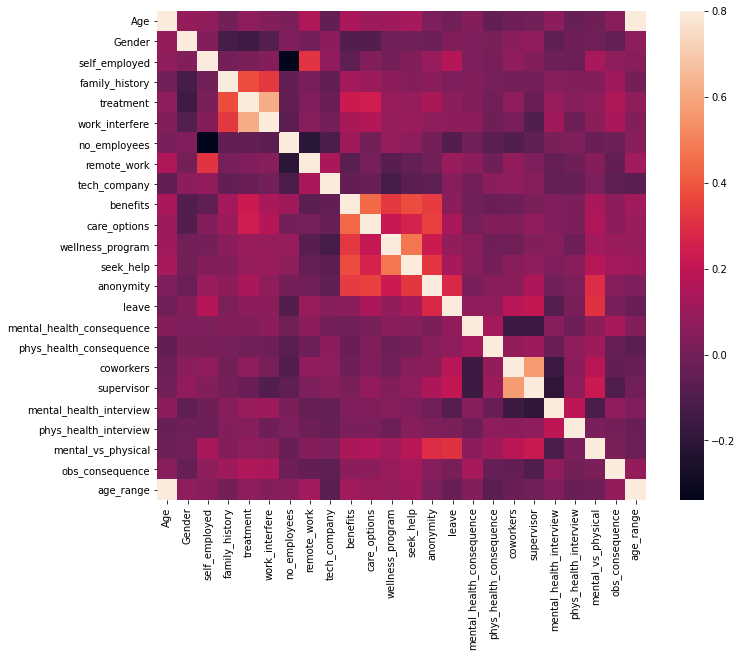

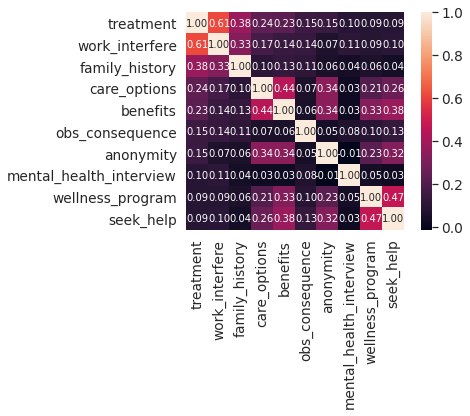

In [15]:
#correlation matrix
corrmat = mentalData.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(mentalData[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Text(0.5, 0, 'Age')

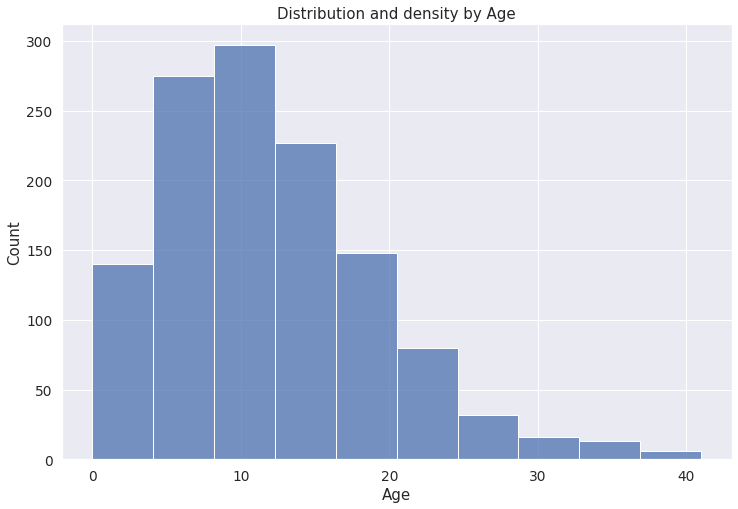

In [16]:
# Distribution and density by Age
plt.figure(figsize=(12,8))
sns.histplot(mentalData["Age"], bins=10)
plt.title("Distribution and density by Age")
plt.xlabel("Age")

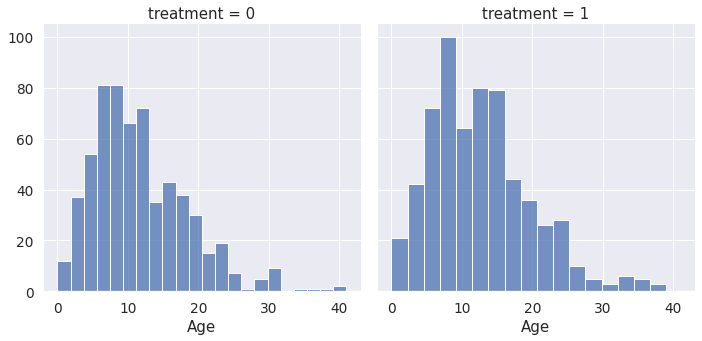

In [17]:
# Separate by treatment or not

g = sns.FacetGrid(mentalData, col='treatment', height=5)
g = g.map(sns.histplot, "Age")

Text(0.5, 1.0, 'Total Distribuition by treated or not')

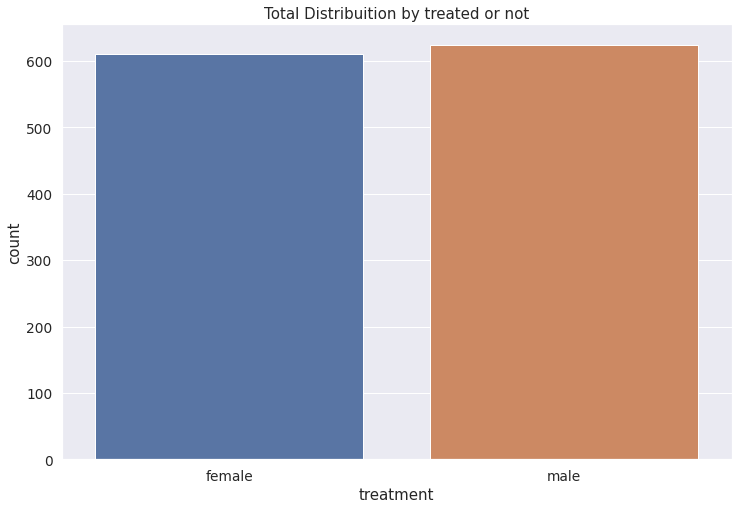

In [18]:
# Let see how many people has been treated
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=mentalData)
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

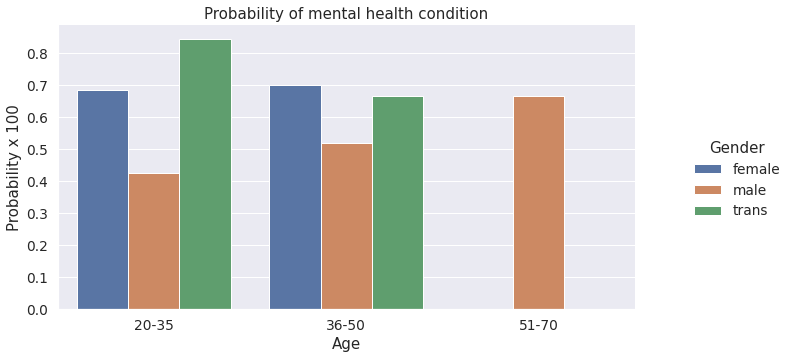

In [19]:
o = labelDict['label_age_range']

g = sns.catplot(x="age_range", y="treatment", hue="Gender", data=mentalData, kind="bar",  ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

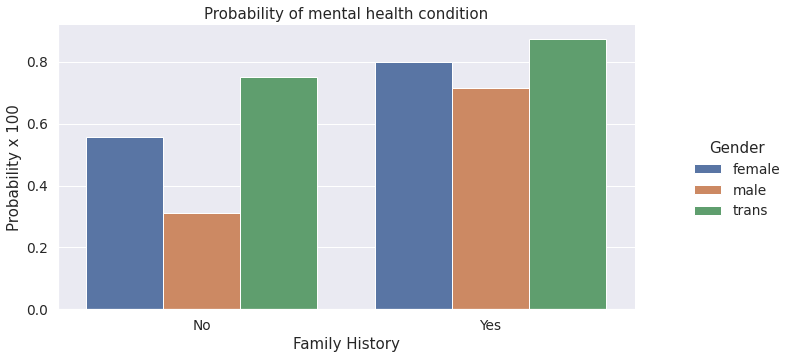

In [20]:
o = labelDict['label_family_history']
g = sns.catplot(x="family_history", y="treatment", hue="Gender", data=mentalData, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

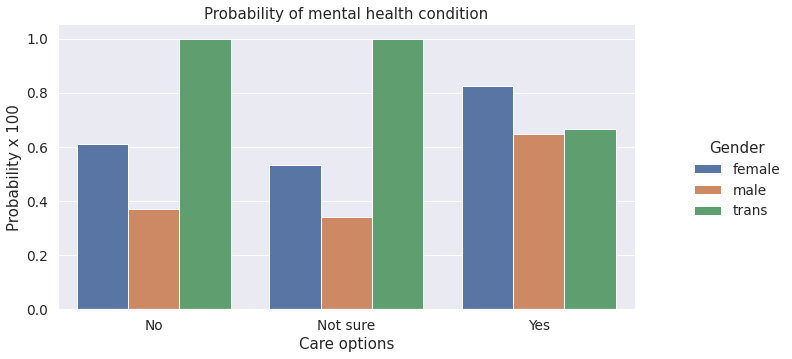

In [21]:
o = labelDict['label_care_options']
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=mentalData, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

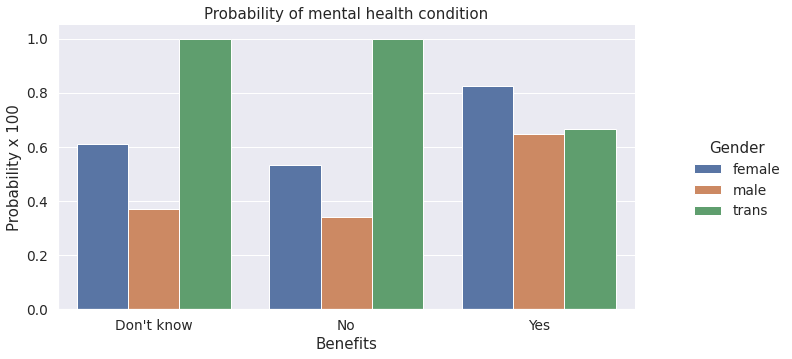

In [22]:
o = labelDict['label_benefits']
g = sns.catplot(x="care_options", y="treatment", hue="Gender", data=mentalData, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

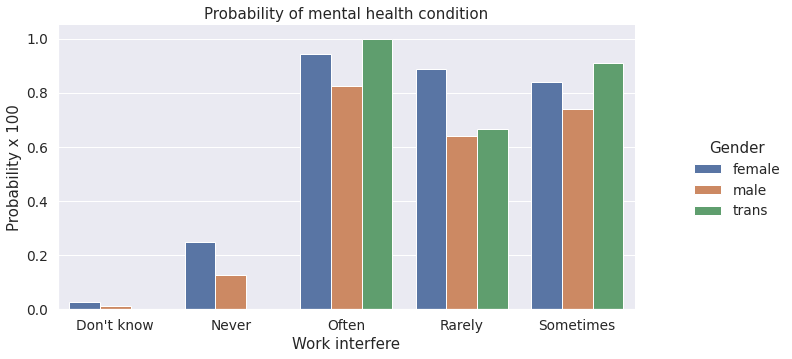

In [23]:
o = labelDict['label_work_interfere']
g = sns.catplot(x="work_interfere", y="treatment", hue="Gender", data=mentalData, kind="bar", ci=None, height=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

In [24]:
age_beforescale = mentalData['Age']
# Scaling Age
scaler = MinMaxScaler()
mentalData['Age'] = scaler.fit_transform(mentalData[['Age']])
mentalData.head()

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.414634,0,0,0,1,2,4,0,1,2,1,1,2,2,2,1,1,1,2,1,0,2,0,1
1,0.585366,1,0,0,0,3,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
2,0.292683,1,0,0,0,3,4,0,1,1,0,1,1,0,1,1,1,2,2,2,2,1,0,0
3,0.268293,1,0,1,1,2,2,0,1,1,2,1,1,1,1,2,2,1,0,0,0,1,1,0
4,0.268293,1,0,0,0,1,1,1,1,2,0,0,0,0,0,1,1,1,2,2,2,0,0,0


In [25]:
# define X and y
feature_cols = ['Age', 'Gender', 'work_interfere', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave']
X = mentalData[feature_cols]
y = mentalData.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
methodDict = {}
rmseDict = ()

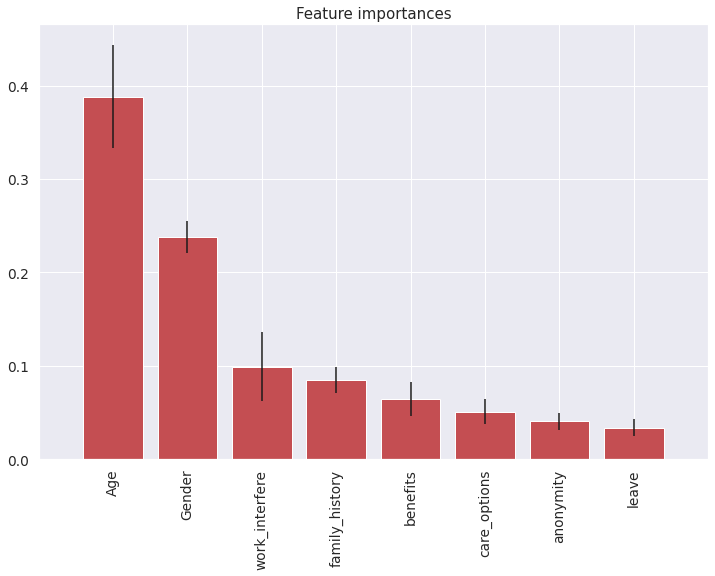

In [26]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [27]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # first argument is true values, second argument is predicted probabilities
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

In [28]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.cv_results_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    
    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

Rand. Best Score:  0.8298190401258851
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 8}
[0.83, 0.83, 0.83, 0.83, 0.83, 0.831, 0.825, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.833, 0.83, 0.83, 0.83, 0.831, 0.835, 0.83]
########### Random Forests ###############
Accuracy: 0.8140161725067385
Null accuracy:
 1    192
0    179
Name: treatment, dtype: int64
Percentage of ones: 0.5175202156334232
Percentage of zeros: 0.4824797843665768
True: [1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0]
Pred: [1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1]


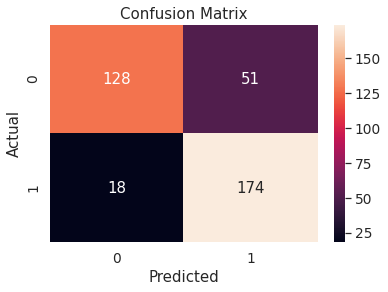

Classification Accuracy: 0.8140161725067385
Classification Error: 0.18598382749326148
False Positive Rate: 0.2849162011173184
Precision: 0.7733333333333333
AUC Score: 0.8106668994413408
Cross-validated AUC: 0.8923786860063961
First 10 predicted responses:
 [1 0 1 0 1 0 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.32363254 0.67636746]
 [0.96771318 0.03228682]
 [0.08798105 0.91201895]
 [0.87550302 0.12449698]
 [0.29502156 0.70497844]
 [0.88883607 0.11116393]
 [0.71836804 0.28163196]
 [0.24026892 0.75973108]
 [0.95017738 0.04982262]
 [0.40979564 0.59020436]]
First 10 predicted probabilities:
 [[0.67636746]
 [0.03228682]
 [0.91201895]
 [0.12449698]
 [0.70497844]
 [0.11116393]
 [0.28163196]
 [0.75973108]
 [0.04982262]
 [0.59020436]]


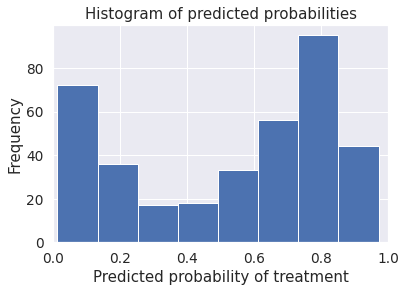

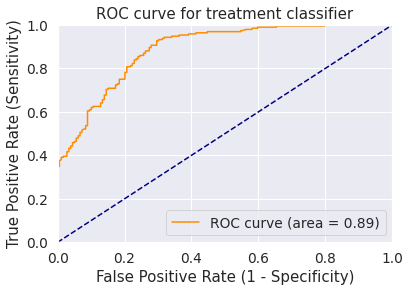

[[128  51]
 [ 18 174]]


In [29]:
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist)
    
    # Building and fitting my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)
    
    print('########### Random Forests ###############')
    
    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['R. Forest'] = accuracy_score * 100

randomForest()

Rand. Best Score:  0.8216758457907162
Rand. Best Params:  {'weights': 'uniform', 'n_neighbors': 15}
[0.82, 0.813, 0.813, 0.815, 0.819, 0.82, 0.82, 0.819, 0.82, 0.817, 0.819, 0.814, 0.815, 0.817, 0.808, 0.808, 0.815, 0.814, 0.811, 0.814]
########### KNeighborsClassifier ###############
Accuracy: 0.8032345013477089
Null accuracy:
 1    192
0    179
Name: treatment, dtype: int64
Percentage of ones: 0.5175202156334232
Percentage of zeros: 0.4824797843665768
True: [1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0]
Pred: [0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1]


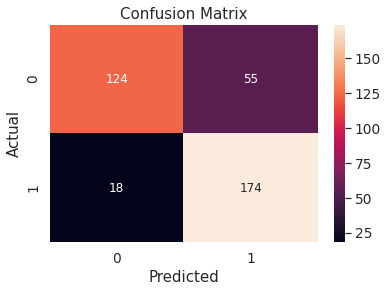

Classification Accuracy: 0.8032345013477089
Classification Error: 0.1967654986522911
False Positive Rate: 0.30726256983240224
Precision: 0.759825327510917
AUC Score: 0.7994937150837989
Cross-validated AUC: 0.8776338210235618
First 10 predicted responses:
 [0 0 1 0 1 0 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.51851852 0.48148148]
 [1.         0.        ]
 [0.03703704 0.96296296]
 [0.85185185 0.14814815]
 [0.2962963  0.7037037 ]
 [0.88888889 0.11111111]
 [0.77777778 0.22222222]
 [0.33333333 0.66666667]
 [1.         0.        ]
 [0.40740741 0.59259259]]
First 10 predicted probabilities:
 [[0.48148148]
 [0.        ]
 [0.96296296]
 [0.14814815]
 [0.7037037 ]
 [0.11111111]
 [0.22222222]
 [0.66666667]
 [0.        ]
 [0.59259259]]


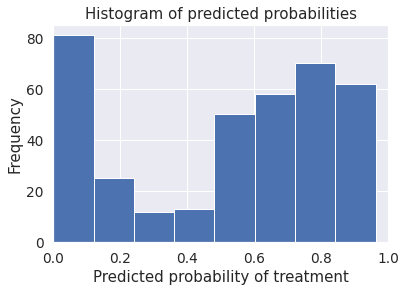

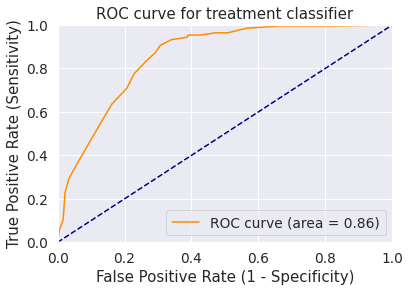

[[124  55]
 [ 18 174]]


In [30]:
def Knn():
    # Calculating the best parameters
    knn = KNeighborsClassifier(n_neighbors=5)

    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
    
    # specify "parameter distributions" rather than a "parameter grid"
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist)
    
    # train a KNeighborsClassifier model on the training set
    knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
    knn.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)
    
    print('########### KNeighborsClassifier ###############')
    
    accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['KNN'] = accuracy_score * 100

Knn()

Rand. Best Score:  0.8298190401258851
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 7, 'min_samples_split': 7}
[0.83, 0.83, 0.828, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.815, 0.829, 0.83, 0.828, 0.828, 0.806, 0.829, 0.83, 0.827, 0.828]
########### Decision Tree classifier ###############
Accuracy: 0.8032345013477089
Null accuracy:
 1    192
0    179
Name: treatment, dtype: int64
Percentage of ones: 0.5175202156334232
Percentage of zeros: 0.4824797843665768
True: [1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0]
Pred: [1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1]


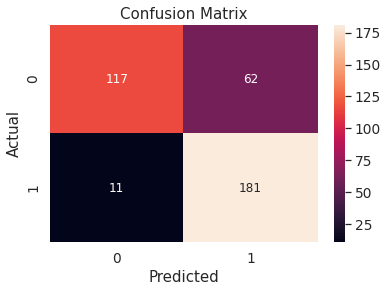

Classification Accuracy: 0.8032345013477089
Classification Error: 0.1967654986522911
False Positive Rate: 0.3463687150837989
Precision: 0.7448559670781894
AUC Score: 0.7981698091247673
Cross-validated AUC: 0.8735287451839542
First 10 predicted responses:
 [1 0 1 0 1 0 0 1 0 1]
First 10 predicted probabilities of class members:
 [[0.41830065 0.58169935]
 [0.98101266 0.01898734]
 [0.12437811 0.87562189]
 [0.890625   0.109375  ]
 [0.12437811 0.87562189]
 [1.         0.        ]
 [0.890625   0.109375  ]
 [0.17931034 0.82068966]
 [0.890625   0.109375  ]
 [0.41830065 0.58169935]]
First 10 predicted probabilities:
 [[0.58169935]
 [0.01898734]
 [0.87562189]
 [0.109375  ]
 [0.87562189]
 [0.        ]
 [0.109375  ]
 [0.82068966]
 [0.109375  ]
 [0.58169935]]


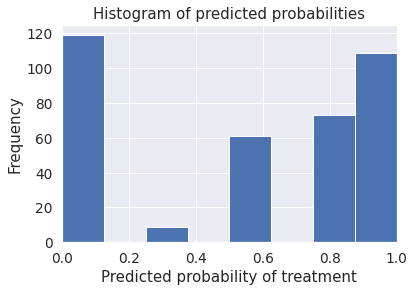

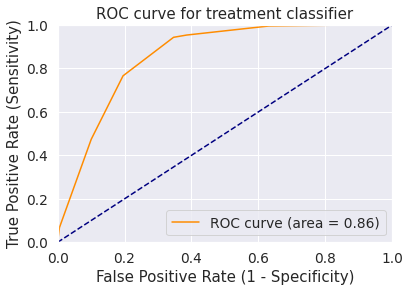

[[117  62]
 [ 11 181]]


In [31]:
def treeClassifier():
    # Calculating the best parameters
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)
    
    # train a decision tree model on the training set
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
    tree.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = tree.predict(X_test)
    
    print('########### Decision Tree classifier ###############')
    
    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Tree clas.'] = accuracy_score * 100

treeClassifier()

In [32]:
import argparse
import tensorflow as tf

batch_size = 100
train_steps = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(1000).repeat().batch(batch_size)

def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

In [33]:
# Define Tensorflow feature columns
age = tf.feature_column.numeric_column("Age")
gender = tf.feature_column.numeric_column("Gender")
family_history = tf.feature_column.numeric_column("family_history")
benefits = tf.feature_column.numeric_column("benefits")
care_options = tf.feature_column.numeric_column("care_options")
anonymity = tf.feature_column.numeric_column("anonymity")
leave = tf.feature_column.numeric_column("leave")
work_interfere = tf.feature_column.numeric_column("work_interfere")
feature_columns = [age, gender, work_interfere, family_history, benefits, care_options, anonymity, leave]

In [34]:
# Build a DNN with 2 hidden layers and 10 nodes in each hidden layer.
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                    hidden_units=[10, 10],
                                    optimizer=lambda: tf.keras.optimizers.Adam(
                                      learning_rate=tf.compat.v1.train.exponential_decay(
                                          learning_rate=0.1,
                                          global_step=tf.compat.v1.train.get_global_step(),
                                          decay_steps=10000,
                                          decay_rate=0.96))
                                    )



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbq9rtd5x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [35]:
model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbq9rtd5x/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.7140621, step = 0
INFO:tensorflow:global_step/sec: 357.365
INFO:tensorflow:loss = 0.44629088, step = 100 (0.281 sec)
INFO:tensorflow:global_step/sec: 489.869
INFO:tensorflow:loss = 0.45273712, step = 200 (0.204 sec)
INFO:tensorflow:global_step/sec: 500.368
INFO:tensorflow:loss = 0.3618084, step = 300 (0.203 sec)
INFO:tensorflow:global_step/sec: 501.262
INFO:ten

In [36]:
# Evaluate the model.
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))

print('\nTest set accuracy: {accuracy:0.2f}\n'.format(**eval_result))

#Data for final graph
accuracy = eval_result['accuracy'] * 100
methodDict['NN DNNClasif.'] = accuracy

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-01-12T13:51:09Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbq9rtd5x/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.60260s
INFO:tensorflow:Finished evaluation at 2021-01-12-13:51:10
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8059299, accuracy_baseline = 0.5175202, auc = 0.88177955, auc_precision_recall = 0.87183017, average_loss = 0.4768075, global_step = 1000, label/mean = 0.5175202, loss = 0.48333228, precision = 0.74590164, prediction/mean = 0.50295514, recall = 0.9479167
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /tmp/tmpbq9rtd5x/model.ckpt-1000

Test set accuracy: 0.81



In [37]:
predictions = list(model.predict(input_fn=lambda:eval_input_fn(X_train, y_train, batch_size=batch_size)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbq9rtd5x/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [38]:
# Generate predictions from the model
template = ('\nIndex: "{}", Prediction is "{}" ({:.1f}%), expected "{}"')

# Dictionary for predictions
col1 = []
col2 = []
col3 = []


for idx, input, p in zip(X_train.index, y_train, predictions):
    v  = p["class_ids"][0] 
    class_id = p['class_ids'][0]
    probability = p['probabilities'][class_id] # Probability
    
    # Adding to dataframe
    col1.append(idx) # Index
    col2.append(v) # Prediction
    col3.append(input) # Expecter

results = pd.DataFrame({'index':col1, 'prediction':col2, 'expected':col3})
results.head()

,index,prediction,expected
0,1216,1,0
1,1017,1,1
2,977,0,0
3,857,0,0
4,675,1,1


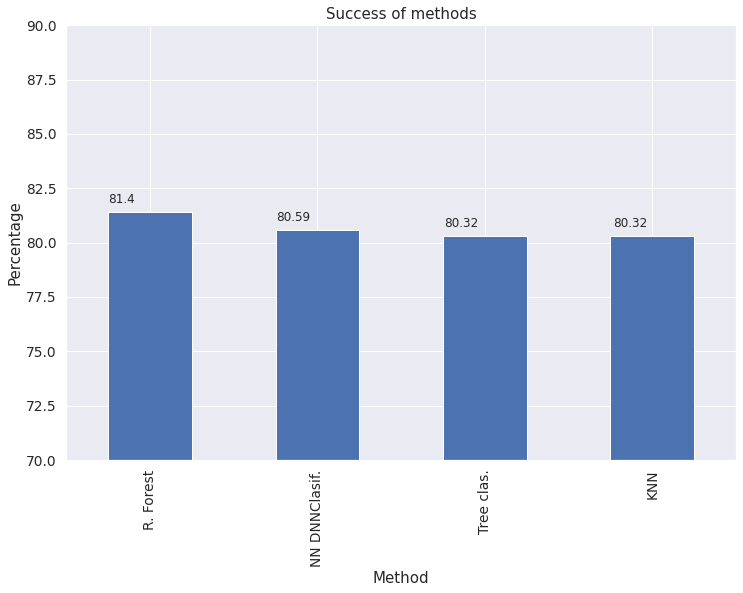

In [39]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()

plotSuccess()

In [40]:
# Generate predictions with the best method
clf = RandomForestClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)

# Write predictions to csv file
# We don't have any significative field so we save the index and other features such as age and gender for visualization
results = pd.DataFrame({'Index': X_test.index, 'Age': X_test.Age, 'Gender': X_test.Gender, 'Treatment': dfTestPredictions})
# Save to file
# This file will be visible after publishing in the output section
results.to_csv('results.csv', index=False)
results.head()

,Index,Age,Gender,Treatment
679,679,0.609756,1,1
46,46,0.195122,1,0
238,238,0.414634,0,1
862,862,0.073171,1,0
913,913,0.317073,1,1
